### MIT Micromasters in Supply Chain Management
This notebook uses the questions and models from the MIT Micromasters course materials, therefore all rights belongs to MIT. I have implemented the models in python.
For more details refer to https://www.edx.org/course/supply-chain-design

## Network Facility Location Problem
Here we trying to solve a network problem with a caditate distribution center locations. The model will be solved to minimize the cost.
This notebook builds a solution for transhipment problem with Pyomo library.


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyomo.environ import *

#### Get network data from a csv file 

In [2]:
df = pd.read_csv('/Users/Jayakhanthan/Desktop/Education/MIT-EDX Micromasters/Supply chain design/Week1 - Network Models/network_data.csv')


In [3]:
df.set_index('ID',inplace=True)

In [4]:
df

,City Name,D,x,y
ID,,,,
BO,Bosten,425,100,80
BR,Brattleboro,12,15,119
CO,Concord,43,76,145
HA,Hartford,125,13,33
MN,Machester,110,80,132
NS,Nashua,86,80,112
NH,New Haven,129,0,0
NL,New London,28,40,6
PO,Portsmouth,66,120,139


#### Candidate locations 
One or more of these locations can be selected as distribution centers

In [5]:
candidates = ['BO','NS','PR','SP','WO']

#### Create distance matrix

In [6]:
for c in candidates:
    X = df.at[c,'x']
    Y = df.at[c,'y']
    df[c] = round(np.sqrt((df.x -  X)**2 + (df.y - Y)**2)-0.5,0)
    

In [7]:
i = 'BO'
j = 'HA'
df.at[j,i]

98.0

In [8]:
data = df
data

,City Name,D,x,y,BO,NS,PR,SP,WO
ID,,,,,,,,,
BO,Bosten,425,100,80,-0.0,37.0,42.0,82.0,34.0
BR,Brattleboro,12,15,119,93.0,65.0,106.0,59.0,68.0
CO,Concord,43,76,145,69.0,33.0,105.0,101.0,72.0
HA,Hartford,125,13,33,98.0,103.0,73.0,27.0,66.0
MN,Machester,110,80,132,55.0,20.0,92.0,93.0,60.0
NS,Nashua,86,80,112,37.0,-0.0,72.0,79.0,41.0
NH,New Haven,129,0,0,128.0,137.0,94.0,63.0,98.0
NL,New London,28,40,6,95.0,113.0,57.0,57.0,71.0
PO,Portsmouth,66,120,139,62.0,48.0,104.0,127.0,85.0


In [9]:
UnitCost = 1
FixedCost = 10000
Pmin = 1
Pmax = 5
S = data['D'].sum()
D = data['D'].sum()

In [10]:
# Add distance in a dictionary
Distance = {}
for c in candidates:
    for i, row in data.iterrows():
        Distance[c,i] = data.at[i,c]

In [11]:
# Add demand to a dictionary
Demand = {}
for i, row in data.iterrows():
    Demand[i] = data.at[i,'D']

### Formulate a network facility location model
This is mixed integer programming model

In [12]:
model = ConcreteModel()
model.dual = Suffix(direction=Suffix.IMPORT)

model.i = Set(initialize = candidates, doc='Candidate locations for DC')
model.j = Set(initialize = data.index.tolist(), doc='Customer locations')

model.d = Param(model.i, model.j, initialize=Distance, doc='Distance in miles')
model.f = Param(initialize=UnitCost, doc='Freight cost in dollars per mile')
model.fcl = Param(initialize=FixedCost, doc='Fixed cost to operate a location')

# Function to calculate cost 
def c_init(model, i, j):
  return model.f * model.d[i,j]
model.c = Param(model.i, model.j, initialize=c_init, doc='Transport cost in dollar per case')

# Initialize flow on arc as a variable
model.x = Var(model.i, model.j, bounds=(0.0,None),domain = NonNegativeReals, doc='Shipment quantities')

# Initialize DC open or close 
model.y = Var(model.i, bounds=(0,1), domain = NonNegativeIntegers, doc = 'DC open decison' )

# Function to get objective function rule
def objective_rule(model):
  return sum(model.c[i,j]*model.x[i,j] for i in model.i for j in model.j) + sum(model.fcl*model.y[i] for i in model.i)

model.cost = Objective(rule=objective_rule, sense=minimize, doc='Total cost')

#Define constraints
def supply_rule(model, i):
  return sum(model.x[i,j] for j in model.j) <= S
model.supply = Constraint(model.i, rule=supply_rule, doc='Observe supply limit at plant i')

def demand_rule(model, j):
  return sum(model.x[i,j] for i in model.i) >= Demand[j] 
model.demand = Constraint(model.j, rule=demand_rule, doc='Satisfy demand at market j')

def linking_constraint(model,i,j):
    return (model.x[i,j] - D * model.y[i] <=0)
model.linking = Constraint(model.i,model.j, rule=linking_constraint, doc='linking constraint')

def node_min(model):
    return sum(model.y[i] for i in model.i) >= Pmin
model.node_min = Constraint(rule=node_min, doc='minimum number of nodes')

def node_max(model):
    return sum(model.y[i] for i in model.i) <= Pmax
model.node_max = Constraint(rule=node_max, doc='maximum number of nodes')

#Solve the model with GLPK solver
results = SolverFactory('glpk').solve(model)

In [466]:
r = []
if 'ok' == str(results.Solver.status):
    print("Total Shipping Costs = ",model.cost())
    for i in model.i:
        for j in model.j:
            if model.x[i,j]() > 0:
                r.append((i,j,model.x[i,j](),model.d[i,j],model.c[i,j]))
                
    result_df = pd.DataFrame(r, columns=['Origin','Destination','Flow','Distance','Cost'])
else:
    print("No Valid Solution Found")

Total Shipping Costs =  66285.0


### Optimized results

In [467]:
model.cost()

66285.0

In [468]:
result_df


,Origin,Destination,Flow,Distance,Cost
0,BO,BO,425.0,-0.0,-0.0
1,BO,CO,43.0,69.0,69.0
2,BO,PO,66.0,62.0,62.0
3,BO,WO,182.0,34.0,34.0
4,BO,MN,110.0,55.0,55.0
5,BO,NS,86.0,37.0,37.0
6,PR,NL,28.0,57.0,57.0
7,PR,PR,1718.0,-0.0,-0.0
8,SP,NH,129.0,63.0,63.0
9,SP,BR,12.0,59.0,59.0


### Visualize the network

In [543]:
def draw_graph(flow, regions, dcs,distance):
    # create networkx graph
    G=nx.DiGraph()
    
    # add nodes
    G.add_nodes_from(regions, s="o")
    G.add_nodes_from(dcs, s="^")
    
    market_color = []
    dc_color = []

    for j in regions:
        market_color.append('blue')
        
    for k in dcs:
        dc_color.append('red')
    
    # add edges
    G.add_edges_from(flow)
    graph_pos = nx.kamada_kawai_layout(G,dist=distance)
    
    nodeShapes = set((aShape[1]["s"] for aShape in G.nodes(data = True)))
    
    #For each node class...
    for aShape in nodeShapes:
        if aShape == 'o':
            color_map = market_color
        else:
            color_map = dc_color
            
        nx.draw_networkx_nodes(G,graph_pos,node_shape = aShape, nodelist = [sNode[0] for sNode in filter(lambda x: x[1]["s"]==aShape,G.nodes(data = True))],node_size=1000, node_color=color_map, alpha=0.3)
    
    nx.draw_networkx_edges(G, graph_pos, width=2, alpha=0.3, edge_color='green')
    nx.draw_networkx_labels(G, graph_pos, font_size=12, font_family='sans-serif')
    
    plt.axis('off')
    plt.show()

In [544]:
flow = result_df[['Origin','Destination']].values.tolist()
dcs = result_df['Origin'].drop_duplicates().values.tolist()
reg = Demand.keys()
distance = result_df['Distance'].to_dict()
k = set(reg).difference(dcs)
regions = k

In [545]:
pos = {}
for i, row in data.iterrows():
    x = data.at[i,'x']
    y = data.at[i,'y']
    pos[i] = x,y

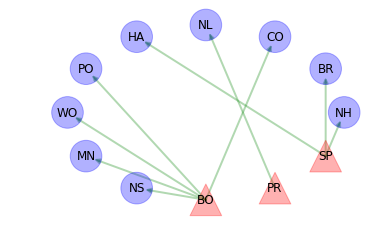

In [547]:
draw_graph(flow,regions,dcs,pos)